# Lab 11: Monte Carlo

Monte Carlo methods are among the most important algorithms for computing integrals. They are our first *statistical* method: we get a remarkably powerful method that is simple to understand as long as we are willing to accept a random error. Why would we do this? Monte Carlo methods shine when the dimensionality of the problem is very large. For example, if you wanted to perform an integral over a set of classical particles like the molecules of air in the room, you have $6N$ dimensions for $N$ particles. Given that there is a very large number of molecules in the room, this is a very large number. 

Recalling our discussion of numerical integration techniques, using Simpson's method or Gaussian quadrature, we divide the interval up into $M$ segments, and the error in our integration falls like $M^{-\delta}$, where $\delta$ is some integer, 4 for Simpson's method. However, if you have $d$ dimensions, the total error in your solution becomes $M^{-\delta/d}$, which is terrible if $d$ gets larger than 4. The more dimensions, the slower and slower the error goes away.

The idea of Monte Carlo is incredibly simple: we randomly sample the high-dimensional space of the problem and use that sampling to construct an estimate of the integral we care about. In order to do so, we'll start by exploring random number generators.

## Random Number Generators

A random number generator (RNG) is a strange beast. It is an algorithm, expressed in a programming language that produces as series of random--uncorrelated--values. However, any algorithm is a series of discrete steps that can be followed in order and should produce the same results every time. So how can that generate randomness? The answer is that it can't. What an RNG can do is produce a series of *pseudorandom* numbers. These are numbers that are for practical purposes random, but are actually determined in a deterministic manner. The literature on RNGs is vast, but we're just going to use the `numpy` RNGs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

#%matplotlib inline
#plt.style.use('ggplot')

Before we begin, you can look at the contents of the `np.random` module by running the `help` command on it. This will generate a lot of useful info, including the functions you can find in it and their documentation.

In [2]:
help(np.random)

Help on package numpy.random in numpy:

NAME
    numpy.random

DESCRIPTION
    Random Number Generation
    
    Use ``default_rng()`` to create a `Generator` and call its methods.
    
    =============== =========================================================
    Generator
    --------------- ---------------------------------------------------------
    Generator       Class implementing all of the random number distributions
    default_rng     Default constructor for ``Generator``
    =============== =========================================================
    
    ============================================= ===
    BitGenerator Streams that work with Generator
    --------------------------------------------- ---
    MT19937
    PCG64
    PCG64DXSM
    Philox
    SFC64
    ============================================= ===
    
    ============================================= ===
    Getting entropy to initialize a BitGenerator
    --------------------------------------------

We're going to play with two functions first, `np.random.rand` and `np.random.randn`. The first should give us a uniform distribution of random numbers on the interval $[0,1).$ The $[$ means "inclusive" and the $)$ means exclusive, so $[0,1)$ means "all the numbers between zero to one, including zero but excluding one"

Let's construct an array of $N = 100$ random samples from `rand`:

In [3]:
N = 100
data = np.random.rand(N)

A good thing to do is to look at the data by plotting it against its sample number, plotting horizontal lines at 0 and 1 to make sure no samples are outside the range we expect:

Text(0, 0.5, 'Value')

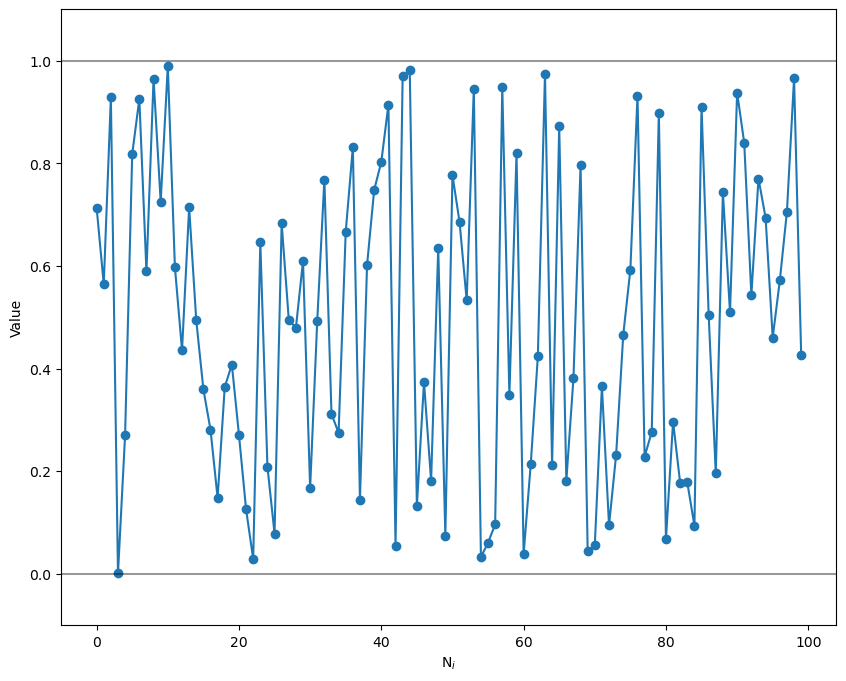

In [4]:
plt.plot(data,marker='o')
plt.axhline(1,color='k',alpha=0.4)
plt.axhline(0,color='k',alpha=0.4)
plt.ylim(-0.1,1.1)
plt.xlabel("N$_{i}$")
plt.ylabel("Value")

We can also double check that quantitatively:

In [5]:
print("(min,max) = ({},{})".format(data.min(),data.max()))

(min,max) = (0.0010215087076315132,0.9895259685838211)


We also need to ensure that the numbers are uniformly distributed. One test for this is to compute the $k$th moment of the distribution:

$$
<x^k> = \frac{1}{N}\sum_{i=0}^N x_i^k
$$

If the numbers are uniformly distributed, then the kth moment is approximately the $k$th moment of the distribution:

$$
\frac{1}{N}\sum_{i=0}^N x_i^k \simeq \int_0^1 x^k P(x) dx \simeq \frac{1}{k+1} + O\left(\frac{1}{\sqrt{N}}\right),
$$

where the second equality only holds for the uniform distribution, in which case the probability distribution $P(x)$ is a constant.

In the cell below, write a function to compute the $k$th moment of a distribution. Also, write a function that uses that moment function to check the uniformity by computing

$$
\sqrt{N} \left|\frac{1}{N}\sum_{i=0}^N x_i^k - \frac{1}{k+1} \right|
$$

for $k=1,2,3,4$. What value should that be close to, if your data is uniformly distributed?

In [9]:
def moment(data,k):
    N = len(data)
    return (data**k).sum()/N

In [10]:
def check_uniform(data):
    N = len(data)
    uniform_check = []
    for k in [1,2,3,4]:
        uniform_check.append(np.sqrt(N) * np.abs(moment(data,k) - 1/(k+1)))
    uniform_check = np.array(uniform_check)
    return uniform_check

Now, use your `check_uniform` function to check `np.random.rand` for N = 10,10000,100000.

In [11]:
for i in [10,100,1000,10000,100000,10000000]:
    data = np.random.rand(i)
    print(check_uniform(data))
    

[0.2043313  0.24873528 0.24007729 0.22622567]
[0.08745886 0.09323164 0.10877489 0.11706754]
[0.25280704 0.29085837 0.29864793 0.29734058]
[0.21183504 0.29992004 0.31967355 0.31146326]
[0.31989938 0.35437822 0.37472703 0.37825753]
[0.1432979  0.1240153  0.11231859 0.10483951]


Finally, one last check is to plot a histogram of your data:

(98000.0, 102000.0)

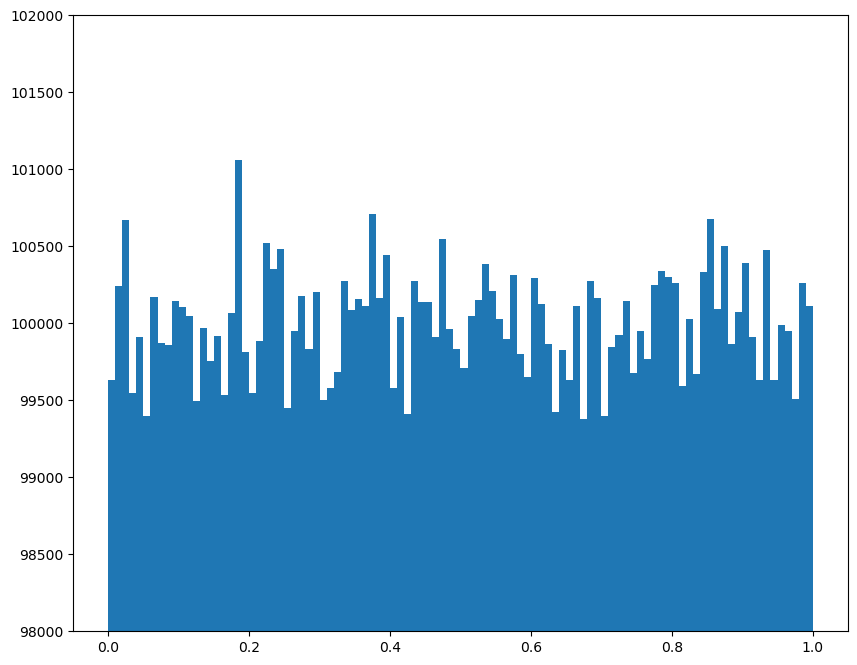

In [12]:
plt.figure()
hist = plt.hist(data,bins=100)
plt.ylim(98000,102000)

It's worth noting that for a small $N$, the histogram may not look very even if you have too many bins. If $N$ is small enough, it won't be very even no matter what--even if the underlying distribution **is** uniformly distributed! This is called sampling error and it is extremely important to understand.

## Finding $\pi$ with random numbers
Before we get to integration, let's start with a simple example. We'll calculate $\pi$ using statistical sampling.

Imagine a circle inscribed in a unit square

(0.225, 0.775, 0.225, 0.775)

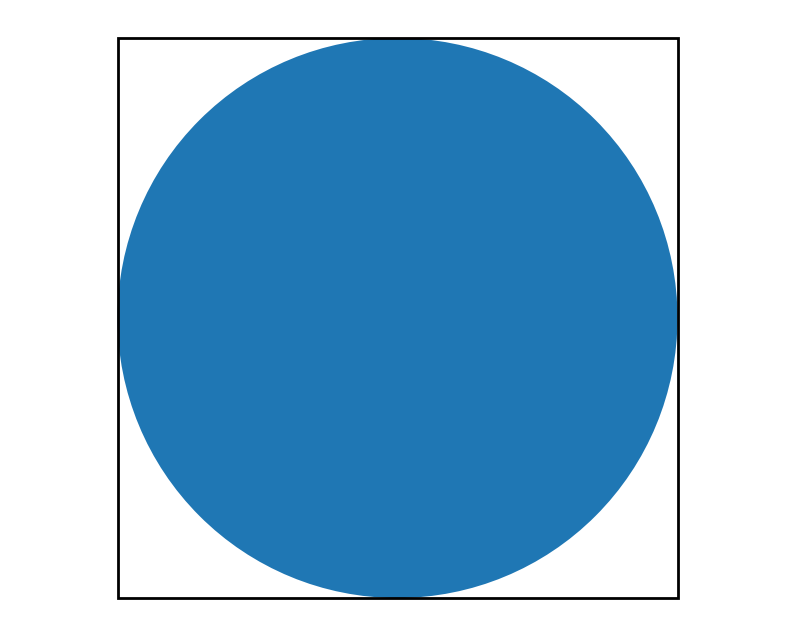

In [13]:
circle = plt.Circle([.5,0.5],0.25,ec=None)
square = plt.Rectangle([0.25,0.25],0.5,0.5,ec=None,fill=False,lw=2,alpha=1,color='k')
fig,ax = plt.subplots()
ax.add_patch(circle)
ax.add_patch(square)
ax.axis('equal')
ax.axis('off')

The radius of the circle is $r_0=1$, so the area of the enclosing square is $A_{sq} = xy = 4$. The area of the circle is, of course, $A= \pi r_0^2$. If we want to find $\pi$, we simply throw random samples down and count how many are inside the circle. The ratio of counts inside the circle to the total number of counts is equal to the ratio of the areas of the circle and square, 

$$
\frac{N_{in}}{N} = \frac{A}{A_{sq}} = \frac{\pi r_0^2}{4}.
$$

Rearranging we arrive at our final result:

$$
\pi = 4 \frac{N_{in}}{N}.
$$

How do we know if a sample is inside or outside the circle? A sample point has a an $x$ and $y$, so we simply compute its radius, $r = \sqrt{x^2 + y^2}$ and check if it is less than $r_0$. 

Here's a simple function to do this. It takes a single argument, $N$, the number of samples you want to take. 

In [14]:
def approx_pi(N):
    n_in = 0
    for i in range(N):
        x = np.random.rand(1)
        y = np.random.rand(1)

        r = np.sqrt(x**2 + y**2)
        if r < 1:
            n_in+=1
    pi = 4*n_in/N
    return pi

Now, make a table using this function for $10 \leq N \leq 10^6$. Make sure $N$ is an integer.

In [15]:
for i in [10,100,1000,10000,100000,1000000]:
    pi = approx_pi(i)
    print("N = {:7d}; pi ~ {}".format(i,pi))

N =      10; pi ~ 3.2
N =     100; pi ~ 2.96
N =    1000; pi ~ 3.092
N =   10000; pi ~ 3.1296
N =  100000; pi ~ 3.1458
N = 1000000; pi ~ 3.140816


That works pretty well, but it's slow. Let's get a quantitative feel for just how slow it is, using the jupyter notebook "cell magic" `%%timeit`. Anything with two `%` is called "cell magic", and will do something cool to the whole cell it's in. In this case `%%timeit` will run the cell a few times, timing how long it takes to run each time. It chooses how many times it needs to run to get a good statistical sample. Let's try it for `N=100000`:

In [16]:
%%timeit
approx_pi(100000)

353 ms ± 541 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


When I tried this, I got about 500 ms. There's a **much** faster way to write the $\pi$ approximation using `numpy` arrays. See if you can write a new function to speed up the computation by eliminating the for loop. Don't replace it with any other kind of loop! A while loop is no faster. You should just use `numpy` arrays alone. 

**As a benchmark, my `approx_pi_fast` was more than a hundred times faster than `approx_pi`.** You shoud be able to hit that too!

In [17]:
def approx_pi_fast(N):
    x = np.random.rand(N)
    y = np.random.rand(N)
    r = np.sqrt(x**2 + y**2)
    n_in = (r < 1).sum()
    return 4*n_in/N

In [18]:
def approx_pi_fast_pow(N):
    x = np.random.rand(N)
    y = np.random.rand(N)
    r = np.sqrt(np.power(x,2) + np.power(y,2))
    n_in = (r < 1).sum()
    return 4*n_in/N

In [19]:
for i in [10,100,1000,10000,100000,1000000]:
    pi = approx_pi_fast(i)
    print("N = {:7d}; pi ~ {}".format(i,pi))

N =      10; pi ~ 3.6
N =     100; pi ~ 3.08
N =    1000; pi ~ 3.148
N =   10000; pi ~ 3.166
N =  100000; pi ~ 3.14356
N = 1000000; pi ~ 3.143812


In [20]:
%%timeit
approx_pi_fast(100000)

1.25 ms ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%%timeit
approx_pi_fast_pow(100000)

4.04 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is not the best way to approximate $\pi$, but it does work! It shows us the power of random numbers. It's worth thinking about that for just a second. We chose (almost) completely random numbers, and used them to find an irrational number of crucial importance in mathematics. 

In [22]:
n = np.arange(10)
print(n)
n_lt_4 = (n < 4)
print(n_lt_4)
print(n_lt_4.sum())

[0 1 2 3 4 5 6 7 8 9]
[ True  True  True  True False False False False False False]
4


## Simple sampling integrals

Let's go back to integration. Remember that the integral is the area under the curve. But now, let's throw random samples on top.

First, we'll define an old friend:

In [23]:
a = 0.
b = 1.
x = np.linspace(a,b,100)
f = 3*x**2 -5.5*x**3 +3.2*x**4

In [24]:
xx = np.random.rand(1000)
yy = np.random.rand(1000)

(0.0, 1.0)

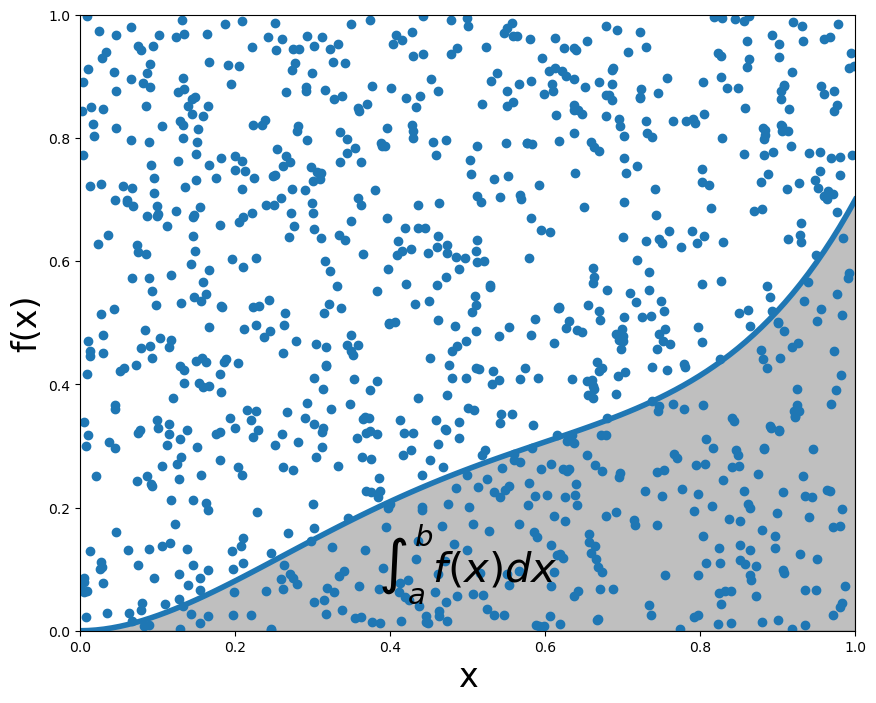

In [25]:
fig,ax = plt.subplots()
verts = [(a, 0)] + list(zip(x, f)) + [(b, 0)]
poly = plt.Polygon(verts, facecolor='0.5', edgecolor='0.5',alpha=0.5)
ax.add_patch(poly)
plt.plot(x,f,linewidth=4)
plt.scatter(xx,yy)
plt.text((b-a)/2.+a,0.08,r"$\int_a^b f(x) dx$",fontsize=30,horizontalalignment='center')

plt.xlabel("x",fontsize=24)
plt.ylabel("f(x)",fontsize=24)
plt.ylim(0.,1.)
plt.xlim(0,1)

Now, if the integral is just the area under the curve, then we can simply count the number of samples below and divide by the total. However, we now face the next question: how to determine if we're below the line.

This is where pure math comes to our rescue: we apply the mean value theorem, which you certainly learned in calculus:

$$
I = \int_a^b f(x) dx = (b-a) <f>,
$$
where $<f>$ is the mean value of the function $f(x)$. 

We can choose samples only along $x_i$, evaluate $f(x_i)$ and approximate 
$$
<f> = \frac{1}{N}\sum_i f(x_i).
$$
Finally, we have our first Monte Carlo method for integration:

$$
I = (b-a)<f> \simeq (b-a)\frac{1}{N}\sum_i f(x_i).
$$

Go ahead and code this up below. Make sure your function returns both the integral and the integral of $f(x)^2$. You'll need this to compute the statistics later.

In [26]:
def integrate_MVMC(f, N, a, b):
    x = (b-a)*np.random.rand(N) + a
    data = f(x)
    m1 = moment(data,1)
    stat_err = np.sqrt((moment(data,2) - m1**2)/(N-1))
    return (b-a)*m1, stat_err

Now, try it on $f(x) = x^n$ for $n = 2$ on $(0,1)$. In order to see how this is doing, we need to compute the variance of the function. The statistical error in the integration is
$$
\delta I = \sqrt{\frac{\mathrm{Var}\ f}{N-1}},
$$
where the variance of the function is
$$
\mathrm{Var}\ f = <f^2> - <f>^2.
$$
Compute $\delta I$ for N = 10,100,1000.

In [27]:
def g(x):
    return x**2

In [28]:
integrate_MVMC(g,100000,0,1)

(0.3335482106987918, 0.0009447758138653848)

## Markov Chains
We now introduce the concept of a Markov chain (MC). We can imagine using the Monte Carlo algorithm for finding area to generalize from something simple like the area of a circle to something complicated, like the area of a pond. Instead of using a computer, we could just throw rocks into a square area circumscribing the pond, and then count the number that go in. Again, comparing that to the number of stones thrown would give us an estimate of the area of the pond. However, unless it's a very small pond, you wouldn't be able to throw stones evenly (and even sampling is the key here) from one position.

Instead, we construct a Markov chain, in which each sample is thrown from the landing point of the previous sample. This may seem a bit silly, but it's actually quite useful because often times it is difficult to redraw a complete distribution of parameters, but modifying from the set you already have is easy.

Here's a slow calculation of pi using a MC. Note that if a sample lands *outside* the box, we reject that one, and double count the position we're landing on. This allows us to construct a reversable chain. Typically, we want to be rejecting about 50% of our samples: if we reject too few, then our calculation will converge very slowly (that is, we will find the right answer only with a very large $N$). If we reject too many, we are not throwing away most of our trials.

Here, $p$ is the size of the step in $x$ and $y$ we will take after each trial. The function returns both the approximate value of $\pi$ and the fraction of accepted trials. Try using it with different $N$ and $p$ to get about 50% accepted trials and a very rough (say 3 digits) approximation to $\pi$ in a reasonable amount of time.

**Challenge: this code can be sped up too!**

In [29]:
def markov_pi(N,p):
    n_in = 0
    accept=0
    x = 0
    y = 0
    for i in range(N):
        dx = 2*p*(np.random.rand(1)-0.5)
        dy = 2*p*(np.random.rand(1)-0.5)
        if (np.abs(x+dx) < 1) and (np.abs(y+dy) < 1):
            x = x+dx
            y = y+dy
            accept += 1
        r = np.sqrt(x**2 + y**2)
        if r < 1:
            n_in+=1
    pi = 4*n_in/N
    return pi,accept/N

In [64]:
print(markov_pi(10000000,1.17))

(3.141056, 0.5008795)
